In [2]:
from astropy.coordinates import SkyCoord
import numpy as np

import lvmguiding
import time
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'lvmifusim/')
import IFU
import scipy.spatial

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Load Gaia Stars and convert their positions to focal plane coordinates

In [3]:
coordinates_crowded = SkyCoord(270.48085943, -28.45945724,unit="deg")
coordinates_median = SkyCoord(195.10462204, -55.248677,unit="deg")
coordinates_empty = SkyCoord(184.18604651, 15.16853933,unit="deg")

#Those are some example fields identified while checking guide star numbers for all LVM pointings

In [4]:
darks_coordinates = np.loadtxt("southern_darks.ascii")

In [5]:
dark_index = 22 #Pick which of the southern darks you want to use

coordinates_dark = SkyCoord(darks_coordinates[dark_index,1],darks_coordinates[dark_index,2],unit="deg")

print(coordinates_dark)

<SkyCoord (ICRS): (ra, dec) in deg
    (14.18200052, -1.96712903)>


In [6]:
my_instrument = lvmguiding.InstrumentParameters()
my_instrument.mag_lim_lower = 21 #If you use a value higher than 17 here, make sure to remote-query the Gaia catalog
remote_query = True

In [36]:
c = coordinates_dark

time0 = time.time()
dd_x_mm,dd_y_mm,culled_cat = lvmguiding.find_guide_stars(c,pa=0,plotflag=False,return_focal_plane_coords=True,remote_catalog=remote_query,inst=my_instrument)
time1 = time.time()
print("Finding the stars in the focal plane within the Gaia catalog took {:.1f} s".format(time1-time0))
print()

print("Coordinates: ",c)
#selection_mag = culled_cat["phot_g_mean_mag"] < maglim
print("Number of sources in focal plane: ",len(dd_x_mm))
#print("Stars that pass mag selection: ",np.sum(selection_mag))

INFO: Query finished. [astroquery.utils.tap.core]
Gaia query:  SELECT source_id, ra,dec,phot_g_mean_mag FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag <= 21 AND 1=CONTAINS(POINT('ICRS',ra,dec), CIRCLE('ICRS',14.182000521067359,-1.9671290320522714, 0.692887394120578))
3914 stars found within 0.692887394120578 deg
Finding the stars in the focal plane within the Gaia catalog took 0.9 s

Coordinates:  <SkyCoord (ICRS): (ra, dec) in deg
    (14.18200052, -1.96712903)>
Number of sources in focal plane:  3914


In [37]:
second_stage_mag_lim = my_instrument.mag_lim_lower #Adapt this if you want to change the maglim AFTER the catalog query

selection_mag = culled_cat["phot_g_mean_mag"] < second_stage_mag_lim
print("Number of sources in focal plane: ",len(dd_x_mm))
print("Stars that pass second stage mag selection: ",np.sum(selection_mag))

Number of sources in focal plane:  3914
Stars that pass second stage mag selection:  3914


In [38]:
# Define the IFU, it has to be doubled checked whether the used lens radius is alright and whether the IFU lib produces the correct results

my_ifu = IFU.IFU(4) 
lens_radii = 0.315/2 * np.ones_like(my_ifu.lensx) #This comes from PDR Document, Figure 4

In [39]:
lens_radii.shape

(61,)

In [40]:
dd_x_mm[selection_mag].shape

(3914,)

In [41]:
xy_list.shape

(1652579, 2)

In [42]:
nmax=10


data_dict={}
data_dict["x"] = dd_x_mm[selection_mag].filled() 
data_dict["y"] = dd_y_mm[selection_mag].filled() 
data_dict["m"] = culled_cat["phot_g_mean_mag"][selection_mag]
print("Creating Tree...")
t0 = time.time()
#xy_list = np.vstack((dd_x_mm[selection_mag].filled(),dd_y_mm[selection_mag].filled())).T
xy_list = np.vstack((data_dict["x"],data_dict["y"])).T
YourTreeName = scipy.spatial.cKDTree(xy_list, leafsize=100)
t1 = time.time()
print("... done! Time: {:.4f} s".format(t1-t0))

Creating Tree...
... done! Time: 0.0031 s


In [43]:
xy_list[0]

array([21.46051241,  4.1834266 ])

In [44]:
current_r

0.1575

In [45]:
ifu_point_list = []

for i in range(len(my_ifu.lensx)):
    current_x = my_ifu.lensx[i]
    current_y = my_ifu.lensy[i]
    
    ifu_point_list.append((current_x,current_y))


In [69]:
query_result = YourTreeName.query(ifu_point_list, k=nmax, distance_upper_bound=lens_radii[0]*2)#

In [70]:
len(ifu_point_list)

61

In [71]:
query_result[0].shape

(61, 10)

In [72]:
query_result[0][:,0]

array([0.11340519, 0.1460988 ,        inf,        inf, 0.29697678,
       0.15734802, 0.15533979, 0.23740364, 0.09780898,        inf,
              inf, 0.2872354 , 0.2578398 , 0.10210743, 0.05400027,
       0.22682714, 0.19027995, 0.14337614, 0.15254543,        inf,
       0.19972434, 0.18278743, 0.11962711,        inf, 0.19204913,
              inf, 0.16947925, 0.15527919, 0.30694949, 0.30908921,
              inf,        inf,        inf,        inf,        inf,
              inf, 0.29928739, 0.00794295, 0.30365975,        inf,
              inf,        inf,        inf,        inf, 0.17242185,
       0.13594651,        inf,        inf, 0.15262804, 0.17431503,
       0.17809883, 0.22935438, 0.20334594, 0.14407067,        inf,
       0.19814232, 0.12328101, 0.22338776, 0.17955321,        inf,
       0.2575456 ])

In [73]:
query_result[1]<3914

array([[ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True, False, False, False, False, False, False,
        False],
       [ True,  True, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True,  True, False, False, False, 

In [89]:
m_array = np.concatenate((np.array(data_dict["m"]),np.array([float("nan")])))

In [103]:
m_neighbours = m_array[query_result[1]]
flux_neighbours = 10**(-0.4*m_neighbours)
flux_combined = np.nansum(flux_neighbours,axis=1)
m_combined = -2.5*np.log10(flux_combined)

/home/haeberle/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [106]:
m_combined

array([15.78925404, 15.86596562,         inf,         inf, 18.51309395,
       18.05166519, 17.06689644, 16.45846973, 17.37730389,         inf,
               inf, 18.73986434, 18.56551743, 17.06790974, 16.63201608,
       17.38640279, 17.39238739, 17.39238739, 15.92890474,         inf,
       18.56551743, 17.00412644, 17.39192749,         inf, 17.39238739,
               inf, 15.92890474, 15.93924713, 20.57071877, 20.57071877,
               inf,         inf,         inf,         inf,         inf,
               inf, 20.57071877, 19.84525944, 20.57071877,         inf,
               inf,         inf,         inf,         inf, 19.84525944,
       19.84525944,         inf,         inf, 19.55805016, 19.55805016,
       20.96523094, 20.02964002, 18.05499649, 18.05499649,         inf,
       17.46361813, 20.96523094, 20.97484398, 18.05499649,         inf,
       17.63406754])

In [104]:
flux_neighbours

array([[4.73061498e-09, 2.82442485e-08, 1.49018924e-07, 3.01397015e-07,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [1.49018924e-07, 3.01397015e-07,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [3.93334844e-08,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [2.82442485e-08, 4.21090218e-09, 2.77084644e-08,            nan,
   

In [102]:
flux_combined

array([4.83390803e-07, 4.50415939e-07, 0.00000000e+00, 0.00000000e+00,
       3.93334844e-08, 6.01636150e-08, 1.49018924e-07, 2.60982934e-07,
       1.11964010e-07, 0.00000000e+00, 0.00000000e+00, 3.19193665e-08,
       3.74794345e-08, 1.48879912e-07, 2.22430105e-07, 1.11029628e-07,
       1.10419314e-07, 1.10419314e-07, 4.25048126e-07, 0.00000000e+00,
       3.74794345e-08, 1.57888109e-07, 1.10466095e-07, 0.00000000e+00,
       1.10419314e-07, 0.00000000e+00, 4.25048126e-07, 4.21018469e-07,
       5.91170146e-09, 5.91170146e-09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.91170146e-09, 1.15317767e-08, 5.91170146e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15317767e-08, 1.15317767e-08, 0.00000000e+00, 0.00000000e+00,
       1.50238050e-08, 1.50238050e-08, 4.11062277e-09, 9.73069796e-09,
       5.99793015e-08, 5.99793015e-08, 0.00000000e+00, 1.03407669e-07,
      

In [95]:
np.nansum(m_neighbours,axis=1)

array([73.05443001, 33.36904907,  0.        ,  0.        , 18.51309395,
       58.70520592, 17.06689644, 54.55142021, 37.48452377,  0.        ,
        0.        , 39.83253098, 18.56551743, 56.05605507, 75.08221436,
       37.59167671, 17.39238739, 17.39238739, 36.92607689,  0.        ,
       18.56551743, 76.1694603 , 37.59769058,  0.        , 17.39238739,
        0.        , 36.92607689, 15.93924713, 20.57071877, 20.57071877,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 20.57071877, 41.19636345, 20.57071877,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 41.19636345,
       41.19636345,  0.        ,  0.        , 19.55805016, 19.55805016,
       20.96523094, 41.59087563, 18.05499649, 18.05499649,  0.        ,
       37.19211769, 20.96523094, 20.97484398, 18.05499649,  0.        ,
       17.63406754])

In [84]:
null_array = np.array([float("nan")])

In [86]:
m_array.shape

(3914,)

In [88]:
m_array = np.concatenate((m_array,null_array))

In [74]:
query_result[1]

array([[ 922,  921,  923,  928, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 923,  928, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 939, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 921,  920,  919, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 923, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 929,  925,  923, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 929,  925, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 920,  919, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 924, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 924,  925,  927, 3914, 3914, 3914, 3914, 3914, 3914, 3914],
       [ 925,  927,  926,  929, 39

In [75]:
query_result[1][query_result[1]<3914]

array([922, 921, 923, 928, 923, 928, 939, 921, 920, 919, 923, 929, 925,
       923, 929, 925, 920, 919, 924, 924, 925, 927, 925, 927, 926, 929,
       926, 929, 935, 935, 724, 725, 924, 927, 924, 926, 925, 926, 927,
       935, 725, 724, 725, 726, 726, 726, 726, 735, 726, 735, 726, 735,
       726, 931, 931, 732, 735, 732, 736, 736, 931, 930, 732, 734, 736,
       930])

In [76]:
data_dict["m"][query_result[1][query_result[1]<3914]]

20.812706
18.872675
17.066896
16.302153
17.066896
16.302153
18.513094
18.872675
20.939062
18.893469
17.066896


In [109]:
m_combined

array([20.81270599, 17.06689644,         inf,         inf,         inf,
       18.87267494, 17.06689644,         inf, 17.47827148,         inf,
               inf,         inf,         inf, 18.56551743, 17.38278237,
               inf,         inf, 17.39238739, 20.98682976,         inf,
               inf,         inf, 20.11340523,         inf,         inf,
               inf,         inf, 15.93924713,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf, 20.57071877,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
       20.62564468,         inf,         inf, 19.55805016,         inf,
               inf,         inf,         inf, 18.05499649,         inf,
               inf, 20.96523094,         inf,         inf,         inf,
               inf])

In [110]:
m_neighbours[:,:2]

array([[20.81270599,         nan],
       [17.06689644,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [18.87267494,         nan],
       [17.06689644,         nan],
       [        nan,         nan],
       [17.47827148,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [18.56551743,         nan],
       [20.00625229, 17.48428535],
       [        nan,         nan],
       [        nan,         nan],
       [17.39238739,         nan],
       [20.98682976,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [20.11340523,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [15.93924713,         nan],
       [        nan,

/home/haeberle/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


Neighbour search took 0.0028s
16 of 61 (26.2%) fibers are contaminated with stars brighter 21 gmag


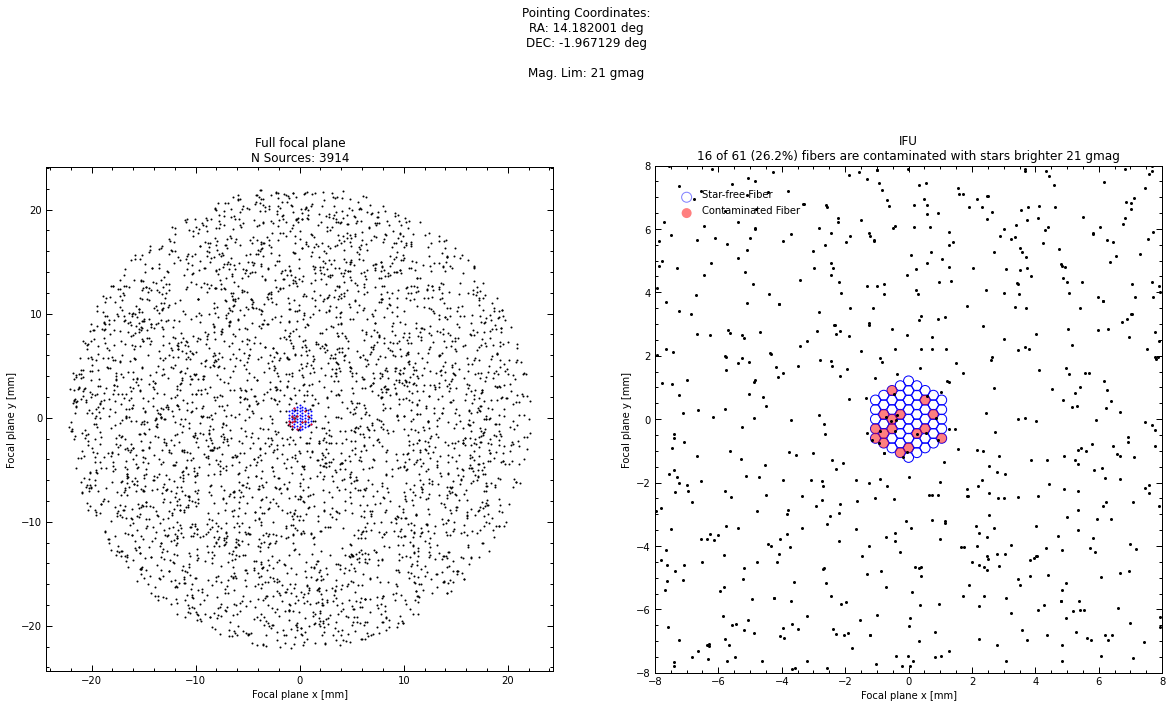

In [107]:
use_tree = True
plotflag = True

use_forloop = True

time0 = time.time()
contaminated = np.array(my_ifu.lensx) < -999

if use_forloop:
    query_result = YourTreeName.query(ifu_point_list, k=nmax, distance_upper_bound=lens_radii[0])#
    
    contaminated = np.isfinite(query_result[0][:,0])
    
    m_neighbours = m_array[query_result[1]]
    flux_neighbours = 10**(-0.4*m_neighbours)
    flux_combined = np.nansum(flux_neighbours,axis=1)
    m_combined = -2.5*np.log10(flux_combined)
    
    
else:

    for i in range(len(my_ifu.lensx)):
        current_x = my_ifu.lensx[i]
        current_y = my_ifu.lensy[i]
        current_r = lens_radii[i]
        if use_tree:
            query_result = YourTreeName.query((current_x,current_y), k=nmax, distance_upper_bound=current_r)#
            x_neighbours = data_dict["x"][query_result[1][np.isfinite(query_result[0])]]
            y_neighbours = data_dict["y"][query_result[1][np.isfinite(query_result[0])]]
            m_neighbours = data_dict["m"][query_result[1][np.isfinite(query_result[0])]]

            #print("Fiber Nr.: {:3d} Nneighbours: {:3d}".format(i,len(m_neighbours)))
            if len(m_neighbours)>0:
                contaminated[i]=True
        else:
            d2 = (current_x-dd_x_mm[selection_mag])**2+(current_y-dd_y_mm[selection_mag])**2
            if d2.min() < current_r**2:
                contaminated[i]=True

        
            
time1 = time.time()

print("Neighbour search took {:6.2}s".format(time1-time0))
print("{} of {} ({:.1f}%) fibers are contaminated with stars brighter {} gmag".format(np.sum(contaminated),len(contaminated),100*np.sum(contaminated)/len(contaminated),second_stage_mag_lim))



if plotflag:
    fig,(ax1,ax2) = plt.subplots(figsize=(20,12),ncols=2)
    fig.suptitle("Pointing Coordinates:\nRA: {:.6f}\nDEC: {:.6f}\n\nMag. Lim: {} gmag".format(c.ra,c.dec,second_stage_mag_lim))
    ax1.set_title("Full focal plane\nN Sources: {}".format(len(dd_x_mm)))


    ax1.set_xlabel("Focal plane x [mm]")
    ax1.set_ylabel("Focal plane y [mm]")
    ax2.set_xlabel("Focal plane x [mm]")
    ax2.set_ylabel("Focal plane y [mm]")

    ax1.plot(dd_x_mm,dd_y_mm,"ko",ms=1)
    ax1.plot(my_ifu.lensx,my_ifu.lensy,"bo",ms=1)
    ax1.plot(np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated],"ro",ms=1)
    ax1.set_aspect("equal")


    ax2.set_xlim(-8,8)
    ax2.set_ylim(-8,8)
    ax2.set_aspect("equal")

    patches = [plt.Circle(center, size) for center, size in zip(np.stack((my_ifu.lensx,my_ifu.lensy),axis=1),lens_radii)]

    patches_contaminated = [plt.Circle(center,size) for center, size in zip(np.stack((np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated]),axis=1),lens_radii[contaminated])]


    #
    coll = matplotlib.collections.PatchCollection(patches, facecolors='none',edgecolor="b")
    coll2 = matplotlib.collections.PatchCollection(patches_contaminated, facecolors='r',alpha=0.5)
    ax2.add_collection(coll)
    ax2.add_collection(coll2)

    ax2.plot(dd_x_mm,dd_y_mm,"ko",ms=2)
    #ax2.plot(dd_x_mm[selection_mag],dd_y_mm[selection_mag],"ko",ms=4)


    ax2.set_title("IFU\n{} of {} ({:.1f}%) fibers are contaminated with stars brighter {} gmag".format(np.sum(contaminated),len(contaminated),100*np.sum(contaminated)/len(contaminated),second_stage_mag_lim))

    circle = plt.Circle((-7,7),current_r,facecolor="none",edgecolor="b",alpha=0.5)
    ax2.add_patch(circle)
    circle = plt.Circle((-7,6.5),current_r,facecolor="r",alpha=0.5)
    ax2.add_patch(circle)
    ax2.text(-6.5,7,"Star-free Fiber")#.format(maglim))
    ax2.text(-6.5,6.5,"Contaminated Fiber")#.format(maglim))






#fig.savefig("dark_patch_stellar_contamination.png",dpi=200,bbox_inches="tight",facecolor="w")

## Check also the guide chips for the chosen pointing

PA:  0
56  stars on guide chip.

PA:  60
71  stars on guide chip.

PA:  120
83  stars on guide chip.

PA:  180
69  stars on guide chip.

PA:  240
67  stars on guide chip.

PA:  300
84  stars on guide chip.



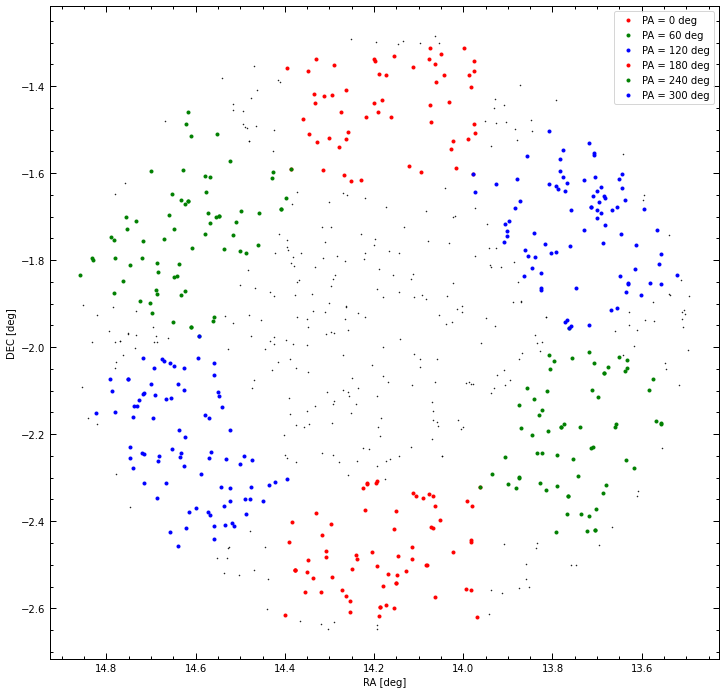

In [10]:
color_array=["r","g","b","r","g","b"]


fig,ax = plt.subplots(figsize=(12,12))

for index,pa in enumerate([0,60,120,180,240,300]):
        print("PA: ",pa)
        #if pa==0:
        #    culled_cat=lvmguiding.cat_full
        ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c,pa=pa,plotflag=False,recycled_cat=culled_cat,inst=my_instrument)
        print(len(chip_xxs), " stars on guide chip.")
        print()
        if pa==0:
            ax.plot(culled_cat["ra"],culled_cat["dec"],"k.",ms=1)
        ax.plot(ras,decs,".",c=color_array[index],label="PA = "+str(pa)+" deg")
        
ax.legend()

ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")
ax.invert_xaxis()

## Save IFUs in a textfile for temporary stand alone version:

In [ ]:
output = np.stack((my_ifu.lensx,my_ifu.lensy,lens_radii),axis=1)

In [ ]:
output.shape

In [ ]:
np.savetxt("ifu_positions.xyr",output,fmt="%12.4f")

In [ ]:
https://wiki.sdss.org/pages/viewpage.action?spaceKey=LVM&title=GeoCoronal+Emission